# General Feature Extraction

In [1]:
#When working on jupyter/spyder notebook on your local machine, run the commands for downloading the below libraries before importing

# pip install -U spacy
# pip install -U spacy-lookups-data
# python -m spacy download en_core_web_sm
# python -m spacy download en_core_web_md
# python -m spacy download en_core_web_lg


In [2]:
#Importing the required libraries

!pip install wordcloud
!pip install -U textblob
!python -m textblob.download_corpora

from textblob import TextBlob
import pandas as pd
import numpy as np
import spacy
import re
from bs4 import BeautifulSoup
import unicodedata
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler 
%matplotlib inline


Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [3]:
#Importing the given training data 
input_train=pd.read_csv('train.csv')
input_train.head() 

,tweet_id,sentiment,tweet_text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


In [4]:
#Importing the given test data file
df_test = pd.read_csv('test_samples.csv')
df_test.head()

,tweet_id,tweet_text
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor..."
1,218775148495515649,Musical awareness: Great Big Beautiful Tomorro...
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,171874368908050432,"Excuse the connectivity of this live stream, f..."


In [5]:
#Checking value counts of each sentiment in the input training data
input_train['sentiment'].value_counts()


positive    9064
neutral     9014
negative    3387
Name: sentiment, dtype: int64

# Processing the input tweets and Extracting Meaningful data


In [6]:
#Counting Word Counts of each tweet in a row 
input_train['word_counts']=input_train['tweet_text'].apply(lambda x: len(str(x).split()))

#Counting Characters in each tweet in a row 
input_train['char_counts']=input_train['tweet_text'].apply(lambda x: len(x))

# Average Word Length in each tweet
def get_avg_word_len(x):
    words=x.split()
    word_len=0
    for word in words:
        word_len=word_len +len(word)
    return word_len/len(words)

input_train['avg_word_len']=input_train['tweet_text'].apply(lambda x: get_avg_word_len(x))


#Removing stop words from each tweet
input_train['stop_words_len'] =input_train['tweet_text'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))

#Count #HashTags and @Mentions in each tweet
input_train['hashtags_count'] = input_train['tweet_text'].apply(lambda x: len([t for t in x.split() if t.startswith('#')]))
input_train['mentions_ count'] = input_train['tweet_text'].apply(lambda x: len([t for t in x.split() if t.startswith('@')]))

###if numeric digit is present in tweet
input_train['numeric_count']=input_train['tweet_text'].apply(lambda x: len([t for t in x.split() if t.isdigit()]))

#Counting upper case words in each tweet
input_train['upper_counts'] = input_train['tweet_text'].apply(lambda x: len([t for t in x.split() if t.isupper()]))

#Checking the first five rows of dataframe with the added new columns
input_train.head()


,tweet_id,sentiment,tweet_text,word_counts,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_ count,numeric_count,upper_counts
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...,14,70,4.071429,4,0,0,0,0
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...,14,81,4.857143,6,0,0,0,0
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...,16,90,4.687500,7,0,0,0,1
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...,22,135,5.181818,7,0,0,0,0
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...,21,143,5.857143,4,0,1,0,0


<H3> Cleaning  the tweets</H3>





In [7]:
#Converting all the tweets into lowercase
input_train['tweet_text'] = input_train['tweet_text'].apply(lambda x: x.lower())



In [8]:
#dictionay of short forms and its replacement with the proper word

contractions = {
"ain't": "am not",    
"aren't": "are not",
"can't": "cannot",
"can't have": "cannot have",
"'cause":"because",
"could've": "could have",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"musn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": "you",
" ur ": "your",
" n ": "and",
}

def cont_to_exp(x):
  if type(x) is str:
    for key in contractions:
      value = contractions[key]
      x = x.replace(key, value)
    return x
  else:
    return x

In [9]:
#Removing any email IDs present in the tweets
input_train['tweet_text'] = input_train['tweet_text'].apply(lambda x: re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9+._-]+\.[a-zA-Z0-9+._-]+)',"",x))

#Removing any URLs present in the tweets
input_train['tweet_text'] = input_train['tweet_text'].apply(lambda x: re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"", x)) 

#Removing tag "RT" - retweet present in the tweets
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: re.sub('RT',"",x))

#Removing any other special character present in the tweets
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))

#Removing digits present in the tweets
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: re.sub('[0-9]', '', x))

#Checking the first five rows of the dataframe after the above changes
input_train.head()

,tweet_id,sentiment,tweet_text,word_counts,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_ count,numeric_count,upper_counts
0,264183816548130816,positive,gas by my house hit ium going to chapel hill ...,14,70,4.071429,4,0,0,0,0
1,263405084770172928,negative,theo walcott is still shituc watch rafa and jo...,14,81,4.857143,6,0,0,0,0
2,262163168678248449,negative,its not that ium a gsp fanuc i just hate nick ...,16,90,4.687500,7,0,0,0,1
3,264249301910310912,negative,iranian general says israelus iron dome canut ...,22,135,5.181818,7,0,0,0,0
4,262682041215234048,neutral,tehranuc mon amour obama tried to establish ti...,21,143,5.857143,4,0,1,0,0


In [10]:
#Each row of tweet_text will be converted back to string from list of words
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: " ".join(x.split()))


In [11]:
#Removing the HTML tags present in the tweets
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

#Removing the Stop words from each tweet
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

In [12]:
#5 mins
#Downloading spacy en_core_web_sm
nlp = spacy.load('en_core_web_sm')

#Function for applying lemmatization in each tweet - base form of the word
def make_to_base(x):
  x_list = []
  doc = nlp(x)

  for token in doc:
    lemma = str(token.lemma_)
    if lemma == '-PRON-' or lemma == 'be':
      lemma = token.text
    x_list.append(lemma)

  return (" ".join(x_list))

#Calling function for each row of the dataframe
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: make_to_base(x))

In [13]:
#Removing the most common and most rare 20 words 

text = ' '.join(input_train['tweet_text'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
f20 = freq_comm[:20] 
rare20 = freq_comm[-20:] 

input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: " ".join([t for t in x.split() if t not in f20]))
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: " ".join([t for t in x.split() if t not in rare20]))

input_train.head()

,tweet_id,sentiment,tweet_text,word_counts,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_ count,numeric_count,upper_counts
0,264183816548130816,positive,gas house hit ium chapel hill sit,14,70,4.071429,4,0,0,0,0
1,263405084770172928,negative,theo walcott shituc rafa johnny deal,14,81,4.857143,6,0,0,0,0
2,262163168678248449,negative,ium gsp fanuc hate nick diaz canut wait february,16,90,4.687500,7,0,0,0,1
3,264249301910310912,negative,iranian general say israelus iron dome canut d...,22,135,5.181818,7,0,0,0,0
4,262682041215234048,neutral,tehranuc mon amour obama try establish tie mul...,21,143,5.857143,4,0,1,0,0


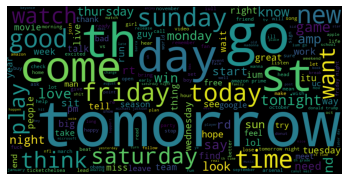

In [14]:
#Word Cloud for the most common words
x = ' '.join(text)
wc = WordCloud(width = 800, height = 400).generate(x)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [15]:
#Tokenization
input_train['tweet_text']=input_train['tweet_text'].apply(lambda x: TextBlob(str(x)).words)

# ML models for text classification

In [16]:
df0=input_train[input_train['sentiment']=='positive']
df2=input_train[input_train['sentiment']=='neutral']
df4=input_train[input_train['sentiment']=='negative']
dfr=df0.append(df4)
dfr=dfr.append(df2)

dfr['tweet_text'] = dfr['tweet_text'].apply(lambda x: " ".join(x)) 
dfr_feat=dfr.drop(labels=['tweet_text', 'sentiment'], axis=1)
y=dfr['sentiment']

In [17]:
sgd=SGDClassifier(n_jobs=-1, random_state=42, max_iter=200)
lgr=LogisticRegression(random_state=42, max_iter=200)
lgrcv=LogisticRegressionCV(cv=2, random_state=42, max_iter=1000)
svm=LinearSVC(random_state=42, max_iter=200)
rfc=RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=200)

clf={'SGD': sgd, 'LR': lgr, 'LGR-CV': lgrcv, 'SVM': svm, 'RFC':rfc}

In [18]:
def classify(X, y):
  scaler=MaxAbsScaler()
  X=scaler.fit_transform(X)

  X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

  for key in clf.keys():
    clf[key].fit(X_train, y_train)

    y_pred=clf[key].predict(X_test)
    ac=accuracy_score(y_test, y_pred)

In [19]:
%%time
classify(dfr_feat, y)

CPU times: user 22.5 s, sys: 3.68 s, total: 26.2 s
Wall time: 17.4 s


In [20]:
#7 mins
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X=tfidf.fit_transform(dfr['tweet_text'])

scaler=MaxAbsScaler()
X=scaler.fit_transform(X)

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)


for key in clf.keys():
  clf[key].fit(X_train, y_train)

  y_pred=clf[key].predict(X_test)
  ac=accuracy_score(y_test, y_pred)


In [21]:
# Repeating the same steps for cleaning and processing the test data as done for training data
#10 mins


df_test['word_counts']=df_test['tweet_text'].apply(lambda x: len(str(x).split()))
df_test['char_counts']=df_test['tweet_text'].apply(lambda x: len(x))
df_test['avg_word_len']=df_test['tweet_text'].apply(lambda x: get_avg_word_len(x))
df_test['stop_words_len'] =df_test['tweet_text'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))
df_test['hashtags_count'] = df_test['tweet_text'].apply(lambda x: len([t for t in x.split() if t.startswith('#')]))
df_test['mentions_ count'] = df_test['tweet_text'].apply(lambda x: len([t for t in x.split() if t.startswith('@')]))
df_test['numeric_count']=df_test['tweet_text'].apply(lambda x: len([t for t in x.split() if t.isdigit()]))
df_test['upper_counts'] = df_test['tweet_text'].apply(lambda x: len([t for t in x.split() if t.isupper()]))
df_test['tweet_text'] = df_test['tweet_text'].apply(lambda x: x.lower())
df_test['tweet_text'] = df_test['tweet_text'].apply(lambda x: re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9+._-]+\.[a-zA-Z0-9+._-]+)',"",x))
df_test['tweet_text'] = df_test['tweet_text'].apply(lambda x: re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"", x))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: re.sub('RT',"",x))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: re.sub('[0-9]', '', x))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: " ".join(x.split()))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: make_to_base(x))
text_test = ' '.join(df_test['tweet_text'])
text_test = text_test.split()
freq_comm = pd.Series(text_test).value_counts()
f20 = freq_comm[:20] #
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: " ".join([t for t in x.split() if t not in f20]))
rare20 = freq_comm[-20:]
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: " ".join([t for t in x.split() if t not in rare20]))
x = ' '.join(text_test)
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x: TextBlob(str(x)).words)
df_test['tweet_text'] = df_test['tweet_text'].apply(lambda x: " ".join(x)) 
dfr_feat=df_test.drop(labels=['tweet_text'], axis=1)


X_train = df_test['tweet_text']
X_train = tfidf.transform(X_train)
X_train = scaler.transform(X_train)

pred_list=[]

for key in clf.keys():
  print(key)
  y_pred=clf[key].predict(X_train)
  pred_list.append(y_pred)

SGD
LR
LGR-CV
SVM
RFC


In [22]:
#downloading the final output files

from google.colab import files
df_SGD = pd.DataFrame(df_test.iloc[:,0])
df_SGD['sentiment']=pred_list[0]
df_SGD.to_csv('output_SGD.csv',index=False)
# files.download('output_SGD.csv')

df_LR = pd.DataFrame(df_test.iloc[:,0])
df_LR['sentiment']=pred_list[1]
df_LR.to_csv('output_LR.csv',index=False)
# files.download('output_LR.csv')

df_LGRCV = pd.DataFrame(df_test.iloc[:,0])
df_LGRCV['sentiment']=pred_list[2]
df_LGRCV.to_csv('output_LGRCV.csv',index=False)
# files.download('output_LGRCV.csv')

df_SVM = pd.DataFrame(df_test.iloc[:,0])
df_SVM['sentiment']=pred_list[3]
df_SVM.to_csv('output_SVM.csv',index=False)
# files.download('output_SVM.csv')

#the model which gives the best accuracy 
df_RFC = pd.DataFrame(df_test.iloc[:,0])
df_RFC['sentiment']=pred_list[4]
df_RFC.to_csv('output_RFC.csv',index=False)
files.download('output_RFC.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>